In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the dataset
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['MedHouseVal'] = data.target

# 1. Introduction


## Background Information

This project aims to predict house prices based on various features such as size, location, and number of bedrooms.
We'll use the California Housing Prices dataset for this analysis.


## Data Source

The dataset is sourced from the California Housing Prices dataset available in the sklearn library.


# 2. Data Exploration


## Summary Statistics

In [4]:
print(df.describe())


             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude   MedHouseVal  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704      2.068558  
std       10.386050      2.135952      2.003532      1.153956  
min        0.692308     32.54000

## Data Visualization

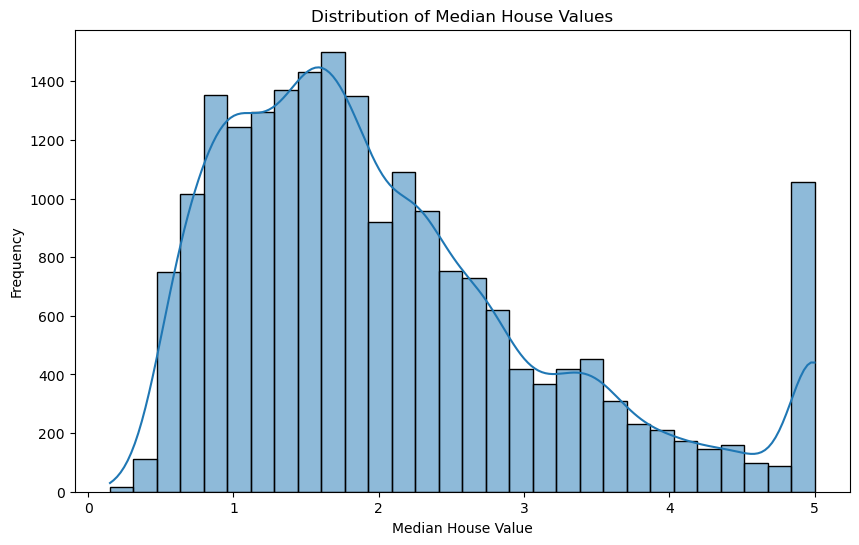

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(df['MedHouseVal'], bins=30, kde=True)
plt.title('Distribution of Median House Values')
plt.xlabel('Median House Value')
plt.ylabel('Frequency')
plt.show()

# 3. Data Cleaning


## Handling Missing Values


In [6]:
df.isnull().sum()  # Check for missing values


MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

#### No missing values in this dataset


## Outlier Detection

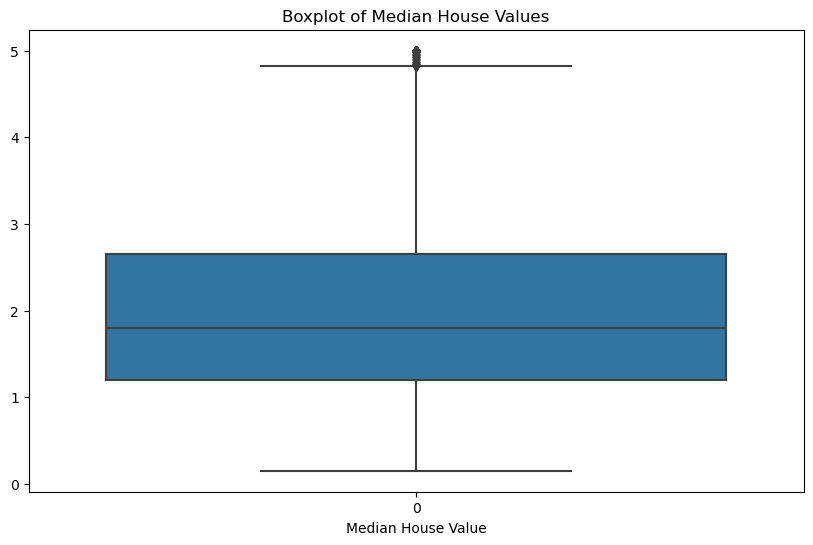

In [7]:
plt.figure(figsize=(10, 6))
sns.boxplot(df['MedHouseVal'])
plt.title('Boxplot of Median House Values')
plt.xlabel('Median House Value')
plt.show()

# 4. Feature Engineering


## Feature Selection


In [9]:
features = df.drop('MedHouseVal', axis=1)
target = df['MedHouseVal']

## Feature Transformation


In [10]:
numeric_features = features.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

# 5. Model Development


## Model Selection


In [11]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor()
}

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

## Hyperparameter Tuning


In [12]:
param_grid = {
    'Random Forest': {
        'model__n_estimators': [50, 100, 200],
        'model__max_features': ['auto', 'sqrt', 'log2']
    },
    'Decision Tree': {
        'model__max_depth': [5, 10, 20, None]
    }
}

best_models = {}
for model_name, model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])
    if model_name in param_grid:
        grid_search = GridSearchCV(pipe, param_grid[model_name], cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)
        best_models[model_name] = grid_search.best_estimator_
    else:
        pipe.fit(X_train, y_train)
        best_models[model_name] = pipe

# 6. Model Evaluation

## Performance Metrics


In [13]:
metrics = {}
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    metrics[model_name] = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    }

metrics_df = pd.DataFrame(metrics).T
print(metrics_df)

                       RMSE       MAE        R2
Linear Regression  0.745581  0.533200  0.575788
Decision Tree      0.650071  0.435339  0.677511
Random Forest      0.489721  0.319557  0.816983


## Residual Analysis


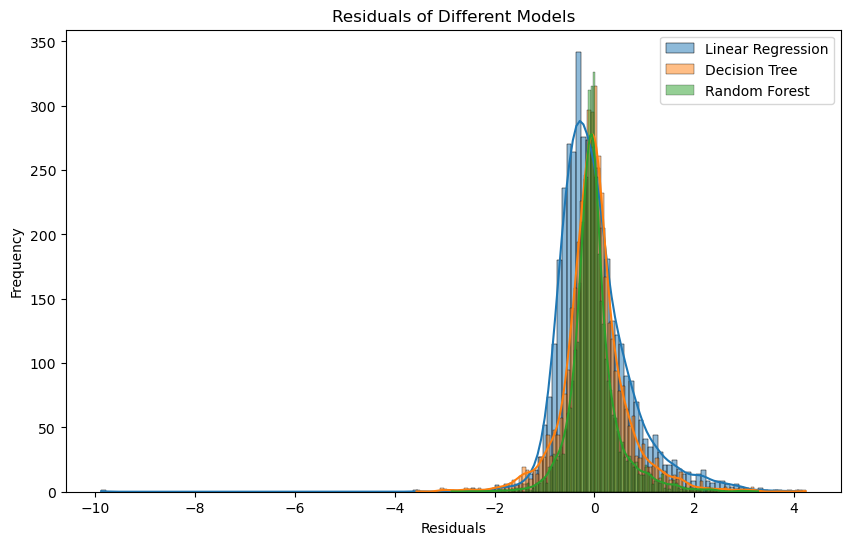

In [14]:
plt.figure(figsize=(10, 6))
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    sns.histplot(y_test - y_pred, kde=True, label=model_name)
plt.title('Residuals of Different Models')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 7. Model Interpretation


## Feature Importance


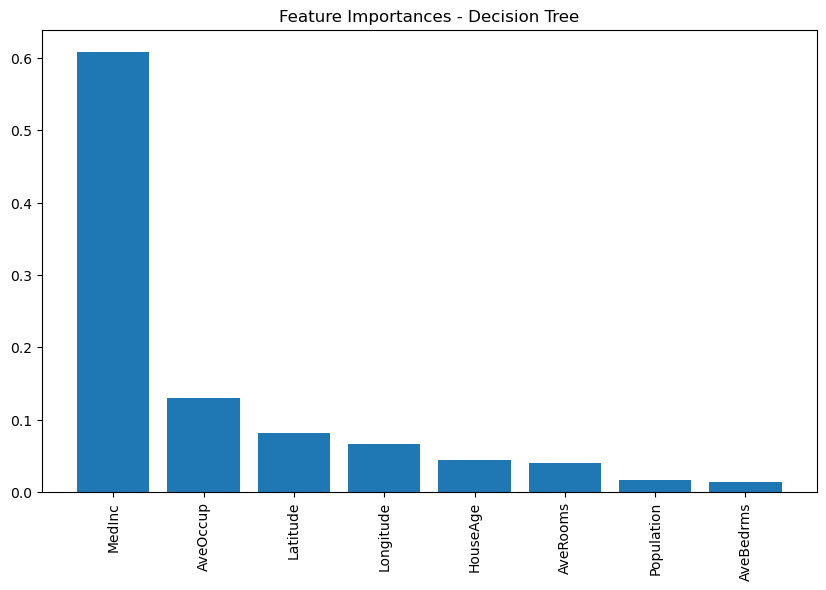

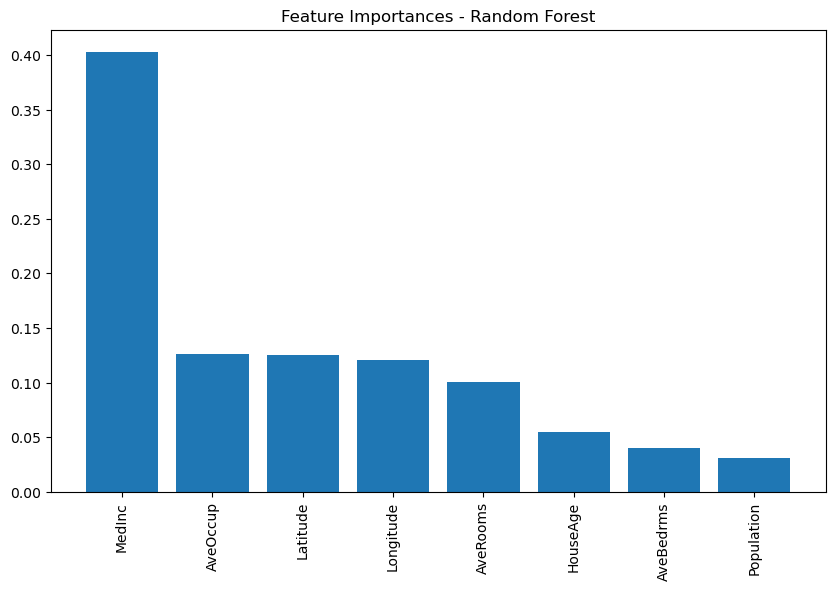

In [15]:
for model_name, model in best_models.items():
    if hasattr(model.named_steps['model'], 'feature_importances_'):
        importances = model.named_steps['model'].feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(10, 6))
        plt.title(f'Feature Importances - {model_name}')
        plt.bar(range(len(importances)), importances[indices], align='center')
        plt.xticks(range(len(importances)), [numeric_features[i] for i in indices], rotation=90)
        plt.show()

## Partial Dependence Plots


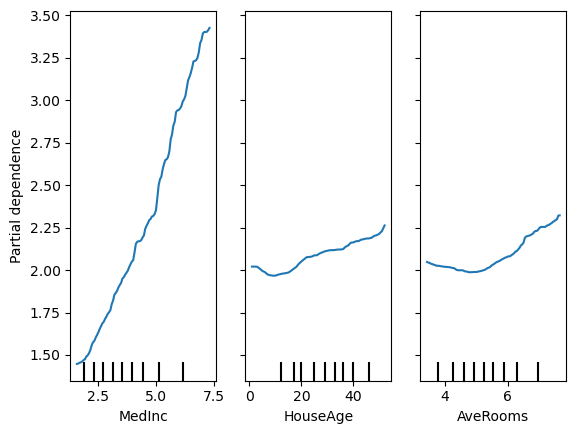

In [17]:
from sklearn.inspection import PartialDependenceDisplay

for model_name, model in best_models.items():
    if model_name == 'Random Forest':
        PartialDependenceDisplay.from_estimator(model, X_train, [0, 1, 2])


# 8. Model Comparison


## Visualization of Model Performance


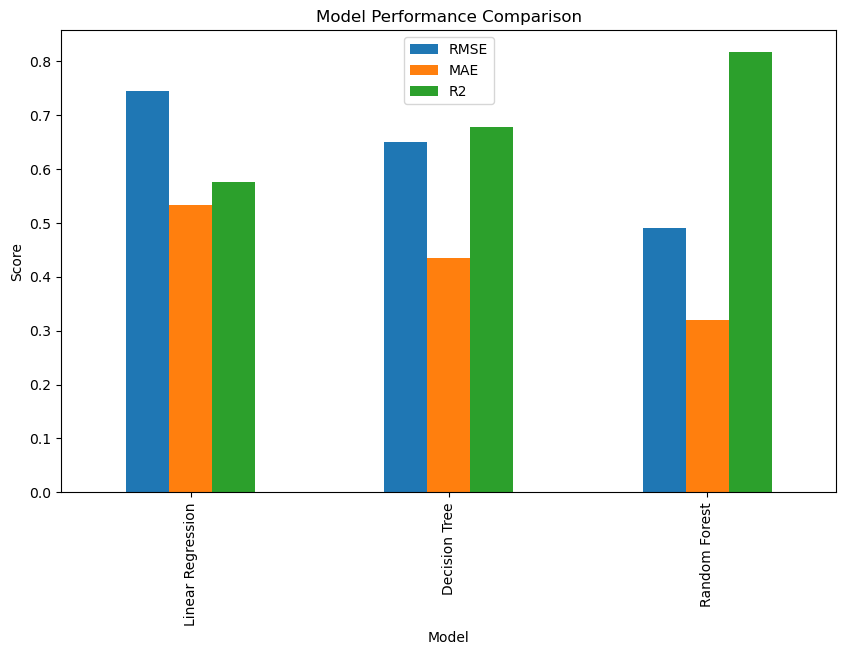

In [18]:
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.show()

# 9. Deployment


## Implementation Strategy


The chosen model can be deployed using a web service for real-time predictions. 
We can use frameworks like Flask or Django to create an API that serves the model predictions.

## Interpretability Comparison

- Linear Regression: High interpretability but may not capture complex relationships.
- Decision Tree: Medium interpretability with ability to capture non-linear relationships.
- Random Forest: Lower interpretability but generally better performance due to ensemble learning.


## Scalability Considerations

To handle larger volumes of data, we can use distributed computing frameworks like Apache Spark.
We should also consider using cloud services like AWS or GCP for deployment and scaling.


# 10. Conclusion


## Key Findings

The Random Forest model provided the best performance based on RMSE and R-squared metrics.
Feature importance analysis showed that features like MedInc and AveOccup have significant impact on house prices.

## Future Work

Future improvements can include adding more features like crime rate, school quality, etc.
We can also experiment with more advanced models like Gradient Boosting and XGBoost for potentially better performance.